# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-06-28 11:48:29.360869: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 11:48:29.387225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 11:48:29.769353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import momentos, gauss, gauss_fit, pulso, delay_pulse_pair, get_mean_pulse_from_set, get_closest, move_to_reference, pulso_poisson, pulso_sigmoid
from Models import model_definition

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo, V28, kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo, V55, kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo, V82, kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **PREPROCESSING**

In [5]:
#---------------------------------- General Definitions ---------------------------------------
Num_casos = 10000
Ntest = int(0.1*Num_casos)
Nc = 2
moments_order = 1

t_shift = 8 #In time steps 
t0 = 80 + np.random.randint(5, size = Num_casos) 
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

In [6]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 4
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.0

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 4
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.0

In [7]:
#------------------------------------------- Simulate detector pulses --------------------
INPUT_dec0 = np.zeros((Num_casos, Nt_new, Nc))
INPUT_dec1 = np.zeros((Num_casos, Nt_new, Nc))

for i in range(Num_casos):
  noise = np.random.normal(scale = 1e-4, size = t_shift)
  
  PULSO_dec0 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

  INPUT_dec0[i,:,0] = PULSO_dec0
  INPUT_dec0[i,:,1] = np.roll(PULSO_dec0, t_shift)
  INPUT_dec0[i,0:t_shift,1] = noise

  INPUT_dec1[i,:,0] = PULSO_dec1
  INPUT_dec1[i,:,1] = np.roll(PULSO_dec1, t_shift)
  INPUT_dec1[i,0:t_shift,1] = noise


#------------------------------------------- Create train set ---------------------------
trainX_dec0, REF_train_dec0 = delay_pulse_pair(INPUT_dec0[:,start:stop,:], new_time_step, t_shift = t_shift, delay_steps = 32)
trainX_dec1, REF_train_dec1 = delay_pulse_pair(INPUT_dec1[:,start:stop,:], new_time_step, t_shift = t_shift, delay_steps = 32)

Text(0.5, 1.0, 'Detector 1')

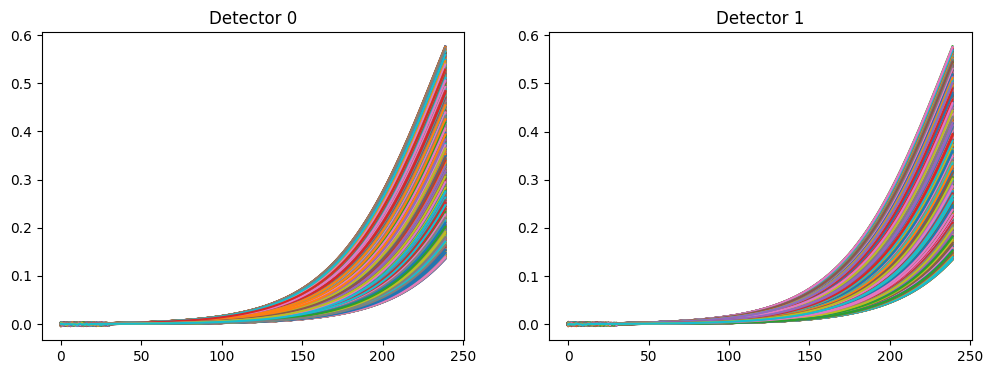

In [8]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
  plt.plot(trainX_dec1[i,:,0])
plt.title('Detector 1')

In [9]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)


#-------------------------------------------------------------- Normalize ---------------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)


#------------------------------------------------- Print Important information ------------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min dec0 =', min_dec0)
print('Max dec0 =', max_dec0)


NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min dec1 =', min_dec1)
print('Max dec1 =', max_dec1)

(10000, 2, 2) NM = 2
Min dec0 = 3.239394580634303
Max dec0 = 26.9236714754176
(10000, 2, 2) NM = 2
Min dec1 = 3.239476555250505
Max dec1 = 26.96552818599643


In [10]:
dispersion_dec0 = np.zeros(trainX_dec0.shape[0])
dispersion_dec1 = np.zeros(trainX_dec1.shape[0])

for i in range(trainX_dec1.shape[0]):
    dispersion_dec0[i] = trainX_dec0[i,-1, 0]
    dispersion_dec1[i] = trainX_dec1[i,-1, 0]

print(np.std(dispersion_dec0))
print(np.std(dispersion_dec1))

0.09985795644177722
0.09974020343616037


# **CREATE TEST SET** 

In [11]:
#------------------------------------------- Create test set ---------------------------
Test_55 = np.zeros((Ntest,Nt_new,Nc))
Test_28 = np.zeros((Ntest,Nt_new,Nc))
Test_82 = np.zeros((Ntest,Nt_new,Nc))
t_shift_test = 8


for i in range(Ntest):
  PULSO_dec0 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  
  Test_55[i,:,0] = PULSO_dec0
  Test_55[i,:,1] = PULSO_dec1

for i in range(Ntest):
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  Test_28[i,:,0] = PULSO_dec0
  Test_28[i,:,1] = np.roll(PULSO_dec1, t_shift_test)
  Test_28[i,0:t_shift_test,1] = noise

for i in range(Ntest):
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  
  Test_82[i,:,0] = np.roll(PULSO_dec0, t_shift_test)
  Test_82[i,0:t_shift_test,0] = noise
  Test_82[i,:,1] = PULSO_dec1

# **FULL TOF**

In [12]:
#---------------------------------------- Create Reference pulse -----------------------
REFERENCE_PULSE_dec0 = np.tile(INPUT_dec0[0,start:stop,0], (Ntest,2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(INPUT_dec1[0,start:stop,0], (Ntest,2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0, order = moments_order)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1, order = moments_order)

M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1 - min_dec1)

In [13]:
#---------------------------------------- Create test set ------------------------------
M_V28 = momentos(Test_28[:,start:stop,:], order = moments_order)
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(Test_55[:,start:stop,:], order = moments_order)
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(Test_82[:,start:stop,:], order = moments_order)
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(1000, 2, 2)
(1000, 2, 2)
(1000, 2, 2)


In [14]:
epochs = 75
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM = NM, NN = 32, STD_INIT = 1)
  model_dec1 = model_definition(NM = NM, NN = 32, STD_INIT = 1)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 5e-5)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 5e-5)

  model_dec0.compile(optimizer = opt_dec0, loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1, loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_V82[:,:,0], M_REF_dec0[:M_V82.shape[0],:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_V82[:,:,1], M_REF_dec1[:M_V82.shape[0],:,0]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_V55[:,:,0], M_REF_dec0[:M_V55.shape[0],:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_V55[:,:,1], M_REF_dec1[:M_V55.shape[0],:,0]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_V28[:,:,0], M_REF_dec0[:M_V28.shape[0],:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_V28[:,:,1], M_REF_dec1[:M_V28.shape[0],:,0]])

     #TOFN_dec0_REF_V55 = np.squeeze(model_dec0.predict([M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]])) - REF_train_dec0
     #TOFN_dec1_REF_V55 = np.squeeze(model_dec1.predict([M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]])) - REF_train_dec1
     
     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
     
     
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
     centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype = 'object')
std = np.array(std, dtype = 'object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

2024-06-28 11:48:40.920629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 11:48:40.940587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 11:48:40.940685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/5


I0000 00:00:1719568122.191663 1706763 service.cc:145] XLA service 0x71279c003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719568122.191688 1706763 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-28 11:48:42.206378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-28 11:48:42.272883: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/40 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - loss: 22.4825

I0000 00:00:1719568122.956649 1706763 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 22.3005
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 21.8696
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 21.6631
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 21.5649
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 21.4980
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 50.1848 
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 47.1056
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 43.1009
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 39.9746
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 37.1810
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 21.4381
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━

(array([1]), array([67])) 0.048090783646412456


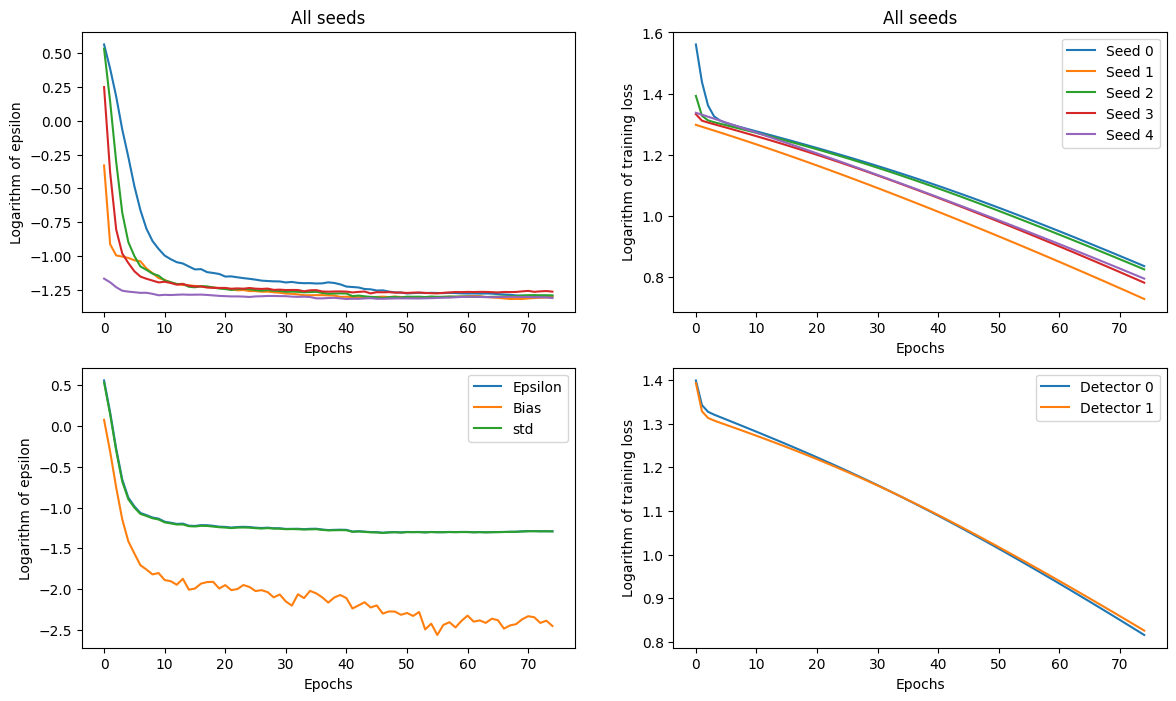

In [15]:
epsilon = np.array(epsilon, dtype = 'float64')
bias = np.array(bias, dtype = 'float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 2

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  #plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label = label)
  plt.plot(np.log10(training_loss_dec1[i,:]), label = label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]), label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.197  FWHM(ns) = 0.133  std(ns) = 0.056
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.120  std(ns) = 0.051
V28: CENTROID(ns) = -0.207  FWHM(ns) = 0.118  std(ns) = 0.050


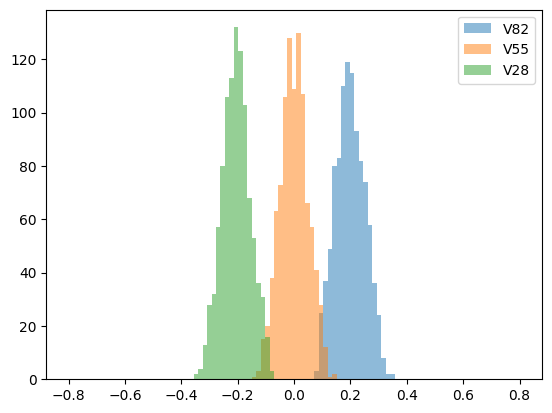

In [16]:
epoch = 68
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 101
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [17]:
import time

time_test_pulses = np.tile(INPUT_dec1[0,start:stop,0], (1000000,2,1)).swapaxes(1,2)
print(time_test_pulses.shape)
M_time_test = momentos(time_test_pulses, order = moments_order)


# Start the timer
start_time = time.time()

with tf.GradientTape() as t:
  with t.stop_recording():
    output_time_test = model_dec0.predict([M_time_test[:,:,0], M_time_test[:,:,1]])
   
# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

(1000000, 240, 2)
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 11s 367us/step
Elapsed time: 17.478567361831665 seconds


# **KAN IMPLEMENTATION**

In [18]:
from kan import *
#------------------------------------------- Simulate detector pulses --------------------
casos_kan = 20
pulse_set = np.zeros((casos_kan, Nt_new, 2))


for i in range(casos_kan):
  PULSO = pulso_sigmoid(tiempo_new, t0[i], A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  pulse_set[i,:,0] = tiempo_new
  pulse_set[i,:,1] = PULSO


# Reshape array to have shape (t, P(t)) 
pulse_set = np.reshape(pulse_set, (pulse_set.shape[0]*pulse_set.shape[1],2)) 

In [19]:
# Define train split size
train_frac = 0.8
Ntrain = int(train_frac*pulse_set.shape[0])

# Create Dataset
dataset = {}
dataset['train_input'] = torch.from_numpy(np.expand_dims(pulse_set[:Ntrain,0], axis = -1)).float()  # Must use float32 to be able to use .initialize_from_another_model later
dataset['train_label'] = torch.from_numpy(np.expand_dims(pulse_set[:Ntrain,1], axis = -1)).float()

dataset['test_input'] = torch.from_numpy(np.expand_dims(pulse_set[Ntrain:,0], axis = -1)).float()
dataset['test_label'] = torch.from_numpy(np.expand_dims(pulse_set[Ntrain:,1], axis = -1)).float()

train loss: 1.07e-01 | test loss: 1.06e-01 | reg: 1.05e+01 : 100%|██| 10/10 [00:11<00:00,  1.20s/it]
train loss: 1.12e-01 | test loss: 1.12e-01 | reg: 1.07e+01 : 100%|██| 10/10 [00:06<00:00,  1.47it/s]
train loss: 6.41e-02 | test loss: 6.37e-02 | reg: 1.06e+01 : 100%|██| 10/10 [00:22<00:00,  2.22s/it]
train loss: 5.03e-02 | test loss: 4.99e-02 | reg: 1.09e+01 : 100%|██| 10/10 [00:22<00:00,  2.29s/it]
train loss: 3.40e-02 | test loss: 3.50e-02 | reg: 1.09e+01 : 100%|██| 10/10 [00:22<00:00,  2.29s/it]
train loss: 3.40e-02 | test loss: 3.50e-02 | reg: 1.09e+01 : 100%|██| 10/10 [00:23<00:00,  2.35s/it]
train loss: 3.40e-02 | test loss: 3.50e-02 | reg: 1.09e+01 : 100%|██| 10/10 [00:53<00:00,  5.32s/it]


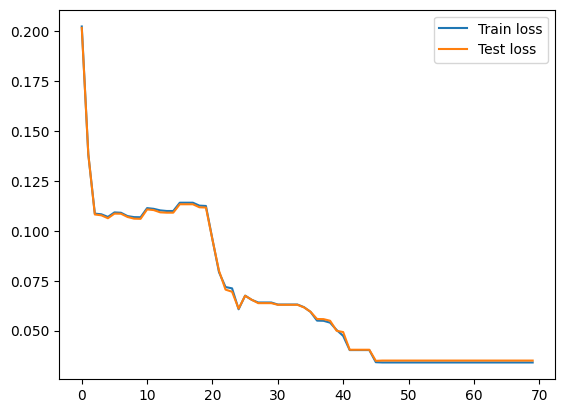

In [20]:
grids = np.array([5, 10, 15, 20, 25, 50, 100])

train_losses = []
test_losses = []

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width = [1, 2, 2, 1], grid = grids[i], k = 3, seed = 0) 
    if i != 1:
        model = KAN(width = [1, 2, 2, 1], grid = grids[i], k = 3, seed = 0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt = "LBFGS", steps = 10);
    train_losses += results['train_loss']
    test_losses += results['test_loss']

plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label = 'Test loss')
plt.legend()

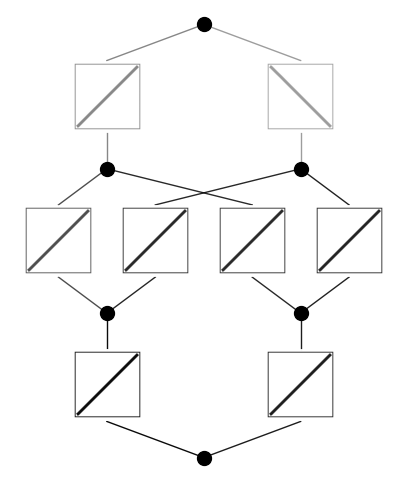

In [21]:
model(dataset['train_input'])
model.plot()

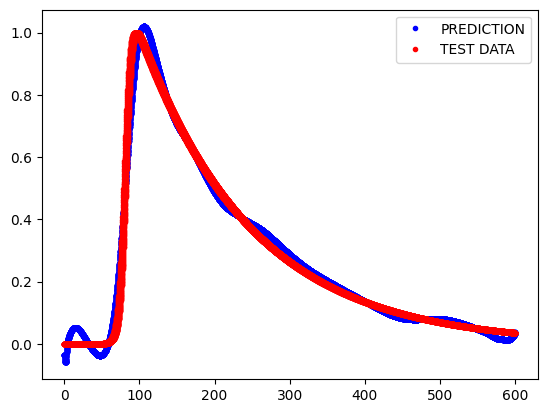

In [22]:
test = model(dataset['test_input'])
test_plot = test.detach().numpy()
plt.plot(dataset['test_input'].detach().numpy(),test_plot, 'b.', label = 'PREDICTION')
plt.plot(dataset['test_input'].detach().numpy(),dataset['test_label'].detach().numpy(), 'r.', label = 'TEST DATA')
plt.legend()

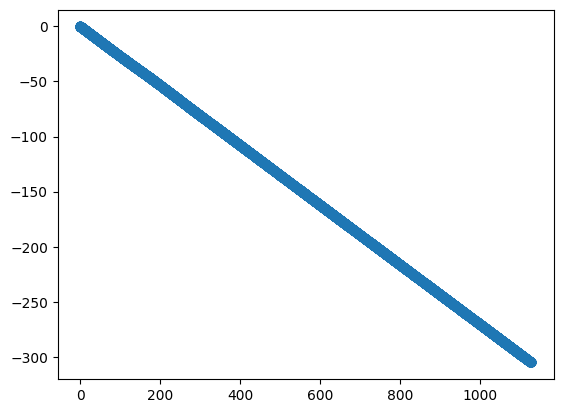

In [29]:
# PLot specific activation functions
l = 2 # Layer
i = 1 # Neuron
j = 0 # Edge

inputs = model.spline_preacts[l][:,j,i]
outputs = model.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

In [30]:
lib = ['x','x^2','exp','log','sqrt','tanh']
model.auto_symbolic(lib = lib)

model.symbolic_formula()[0][0]

fixing (0,0,0) with tanh, r2=1.000000238418579
fixing (0,0,1) with tanh, r2=1.0000003576278687
fixing (1,0,0) with x, r2=1.0000004768371582
fixing (1,0,1) with tanh, r2=1.0000001192092896
fixing (1,1,0) with x, r2=1.0000003576278687
fixing (1,1,1) with tanh, r2=1.0000003576278687
fixing (2,0,0) with tanh, r2=0.9999988675117493
fixing (2,1,0) with x, r2=0.9999977946281433


-2.10382311355765